In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install hmmlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.1/161.1 kB 3.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

In [ ]:
df['datetime'] = pd.to_datetime(df['DATA'] + ' ' + df['HORA'])
df.set_index('datetime', inplace=True)
df['datetime'] = pd.to_datetime(df['DATA'] + ' ' + df['HORA'])

In [ ]:
features = df[['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
                 'UMIDADE RELATIVA DO AR, HORARIA (%)',
                 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
                 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
                 'VENTO, VELOCIDADE HORARIA (m/s)',
                 'RADIACAO GLOBAL (KJ/m²)']]

## functions

In [ ]:
def split_train_test(df, column, date='2021-01-01', columns_to_remove=[]):
  df['DATA'] = pd.to_datetime(df['DATA'])
  df['datetime'] = pd.to_datetime(df['DATA'].astype(str) + ' ' + df['HORA'])
  if 'Unnamed: 0' in df.columns: df = df.drop(columns='Unnamed: 0')
  df.fillna(0)

  training_mask = df["datetime"] < date
  training_data = df.loc[training_mask]

  testing_mask = df["datetime"] >= date
  testing_data = df.loc[testing_mask]
  print(f'train= {training_data.shape} || test= {testing_data.shape}')

  testing_dates = testing_data["datetime"]

  figure, ax = plt.subplots(figsize=(20, 5))
  training_data.plot(ax=ax, label="Training", x="DATA", y=column)
  testing_data.plot(ax=ax, label="Testing", x="DATA", y=column)
  plt.show()

  X_train = training_data[training_data.columns.difference(['DATA', 'HORA', column] + columns_to_remove)]
  y_train = training_data[column]

  X_test = testing_data[testing_data.columns.difference(['DATA', 'HORA', column] + columns_to_remove)]
  y_test = testing_data[column]

  X_train = X_train.fillna(0)
  X_test = X_test.fillna(0)
  y_train = y_train.fillna(0)
  y_test = y_test.fillna(0)

  return X_train, y_train, X_test, y_test, testing_dates

In [ ]:
def grid_search(X_train, y_train):
  model = XGBRegressor()

  param_grid = {
      'eta': [0.1, 0.2, 0.5],
      "colsample_bytree":[0.5, 0.75, 1],
      "subsample":[0.5, 0.75, 1],
      'max_depth': range (2, 10, 1),
      'learning_rate': [0.1, 0.01, 0.05]
  }

  grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3, verbose=1)
  grid_search.fit(X_train, y_train)

  print("Best parameters found: ", grid_search.best_params_)
  return grid_search.best_params_

In [ ]:
def create_hmm(df, n_states, n_iter):
  df_aux = df.copy()

  scaler = StandardScaler()
  features_scaled = scaler.fit_transform(features)

  model = GaussianHMM(n_components=n_states, n_iter=n_iter)
  model.fit(features_scaled)

  hidden_states = model.predict(features_scaled)

  df_aux['hidden_state'] = hidden_states

  return df_aux

In [ ]:
def plot_correlation_matrix(df):
  df_aux = df.copy()

  df_aux = df_aux.rename(columns={ 'hour': 'hora',
                 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'temperatura',
                 'UMIDADE RELATIVA DO AR, HORARIA (%)': 'umidade',
                 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)': 'precipitação',
                 'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'pressão atmosférica',
                 'VENTO, VELOCIDADE HORARIA (m/s)': 'vento',
                 'RADIACAO GLOBAL (KJ/m²)': 'radiação solar',
                          'hidden_state': 'hmm_state'})

  correlation_matrix =  df_aux[[
                 'hora',
                 'temperatura',
                 'umidade',
                 'precipitação',
                 'pressão atmosférica',
                 'vento',
                 'radiação solar', 'hmm_state']].corr()

  plt.figure(figsize=(10, 8))
  sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
  plt.title('Matriz de Correlação')
  plt.show()

In [ ]:
def train(dtrain, dtest, params, num_boost_rounds):

  model = xgb.train(params, dtrain, num_boost_round=num_boost_rounds)

  predictions = model.predict(dtest)

  return model, predictions

In [ ]:
def plot_feature_importance(model):
  plot_importance(model, height=0.9)

In [ ]:
def evaluate_model(y_test, prediction):
  print(f"MAE: {mean_absolute_error(y_test, prediction)}")
  print(f"MSE: {mean_squared_error(y_test, prediction)}")
  print(f"MRSE: {np.sqrt(mean_squared_error(y_test, prediction))}")

In [ ]:
def plot_predictions(testing_dates, y_test, prediction):
  df_test = pd.DataFrame({"Data": testing_dates, "actual": y_test, "Predição": prediction })
  figure, ax = plt.subplots(figsize=(10, 5))
  df_test.plot(ax=ax, label="Correto", x="Data", y="actual")
  df_test.plot(ax=ax, style='-', label="Prediction", x="Data", y="Predição")
  plt.legend(["Correto", "Predição"])
  plt.show()

## radiação

In [ ]:
# df = create_hmm(df, n_states=7, n_iter=1000)

plot_correlation_matrix(df)

salvando resultado em arquivo

In [ ]:
# df.to_csv('/content/drive/MyDrive/Trabalho AD/inmet/hmm_rad_77_inmet.csv')

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Trabalho AD/inmet/hmm_rad_77_inmet.csv')

In [5]:
df['RADIACAO GLOBAL (KJ/m²)'].describe()

count    147044.000000
mean        681.906038
std        1064.827676
min           0.000000
25%           0.000000
50%           6.400000
75%        1092.500000
max        5308.300000
Name: RADIACAO GLOBAL (KJ/m²), dtype: float64

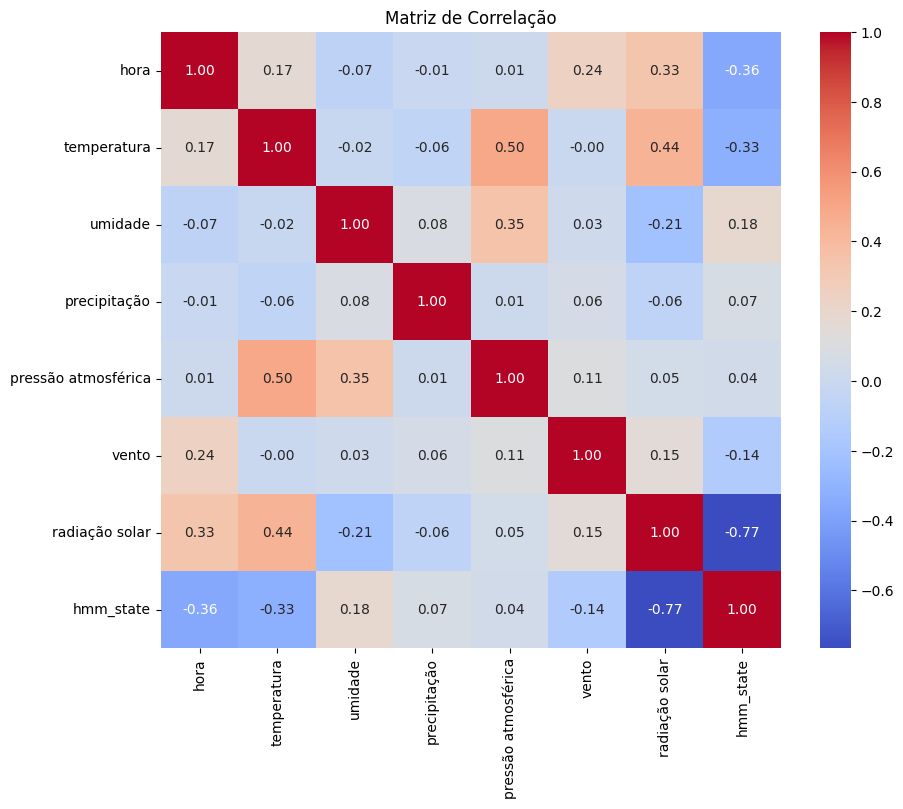

In [ ]:
plot_correlation_matrix(df)

In [ ]:
df

,Unnamed: 0,datetime,DATA,HORA,"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),"UMIDADE RELATIVA DO AR, HORARIA (%)",UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),...,"VENTO, RAJADA MAXIMA (m/s)",RADIACAO GLOBAL (KJ/m²),"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)",year,month,day,hour,minute,second,hidden_state
0,0,2007-05-22 04:00:00,2007-05-22,04:00,23.1,23.2,23.0,83.0,85.0,83.0,...,4.0,0.0,0.0,2007,5,22,4,0,0,5
1,1,2007-05-22 05:00:00,2007-05-22,05:00,22.9,23.0,22.8,85.0,86.0,84.0,...,4.3,0.0,0.0,2007,5,22,5,0,0,5
2,2,2007-05-22 06:00:00,2007-05-22,06:00,23.0,23.3,23.0,83.0,83.0,81.0,...,3.4,0.0,0.0,2007,5,22,6,0,0,5
3,3,2007-05-22 07:00:00,2007-05-22,07:00,22.9,23.1,22.9,82.0,83.0,81.0,...,3.9,0.0,0.0,2007,5,22,7,0,0,5
4,4,2007-05-22 08:00:00,2007-05-22,08:00,23.4,23.6,23.4,76.0,76.0,74.0,...,6.0,0.0,0.0,2007,5,22,8,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147039,147039,2024-02-28 05:00:00,2024-02-28,05:00,25.7,26.3,25.6,99.0,99.0,97.0,...,8.0,0.0,0.0,2024,2,28,5,0,0,5
147040,147040,2024-02-28 06:00:00,2024-02-28,06:00,26.7,26.8,25.2,97.0,100.0,97.0,...,6.3,0.0,0.0,2024,2,28,6,0,0,5
147041,147041,2024-02-28 07:00:00,2024-02-28,07:00,26.9,26.9,26.3,95.0,97.0,95.0,...,4.9,0.0,0.0,2024,2,28,7,0,0,5
147042,147042,2024-02-28 08:00:00,2024-02-28,08:00,26.8,27.0,26.7,93.0,95.0,93.0,...,8.0,0.0,0.0,2024,2,28,8,0,0,5


train= (122972, 27) || test= (24072, 27)


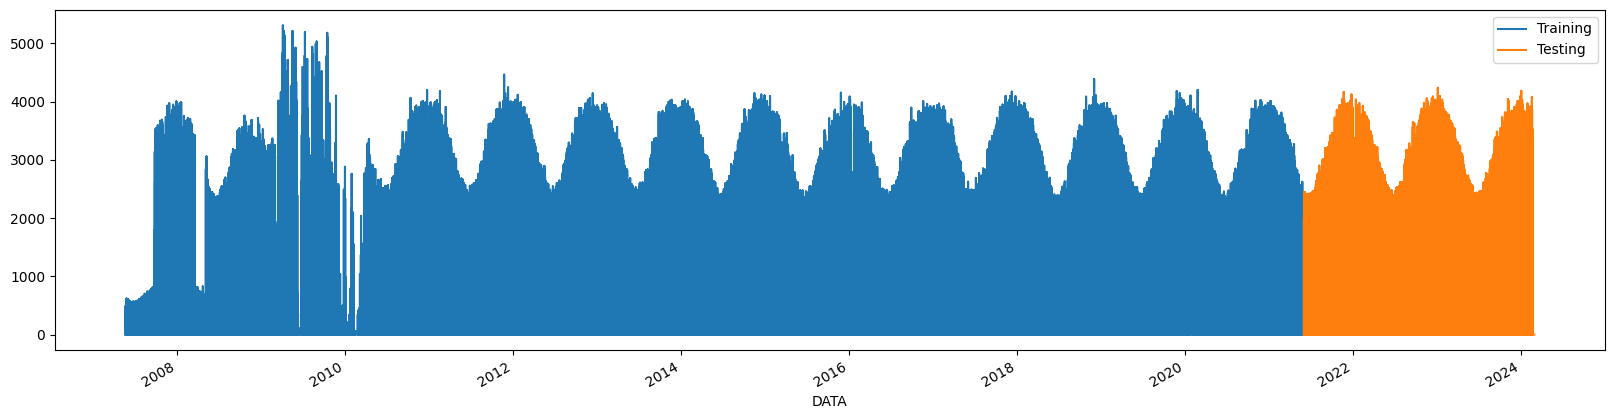

MAE: 163.82617140155125
MSE: 116613.4764438051
MRSE: 341.4871541417116


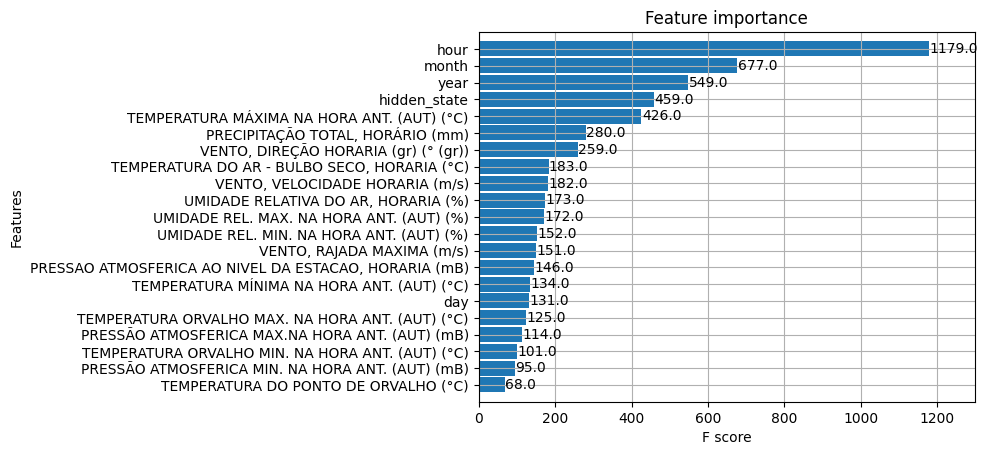

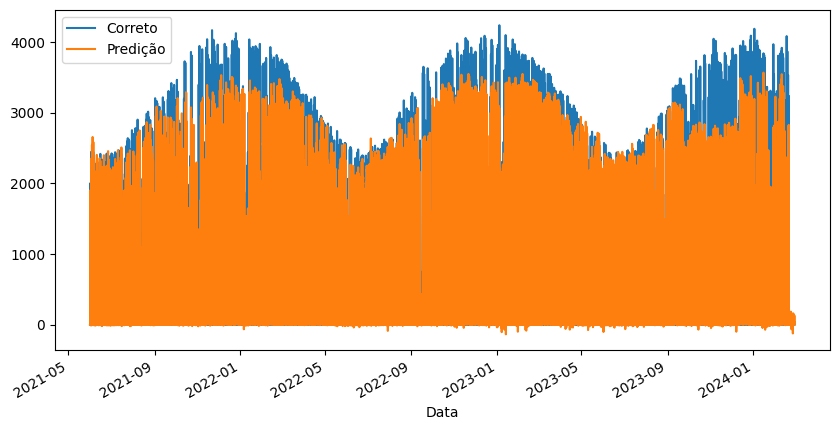

In [ ]:
X_train, y_train, X_test, y_test, testing_dates = split_train_test(df, column='RADIACAO GLOBAL (KJ/m²)', date='2021-06-01', columns_to_remove=['DATA', 'HORA', 'datetime'])

dtrain = xgb.DMatrix(X_train, label=y_train)

dtest = xgb.DMatrix(X_test)

# params = grid_search(X_train, y_train)
params = {'colsample_bytree': 1, 'eta': 0.1, 'learning_rate': 0.05, 'max_depth': 6, 'subsample': 0.5}

radiation_model, predictions = train(dtrain, dtest, params=params, num_boost_rounds=100)

plot_feature_importance(model=radiation_model)

evaluate_model(y_test, predictions)

plot_predictions(testing_dates, y_test, predictions)

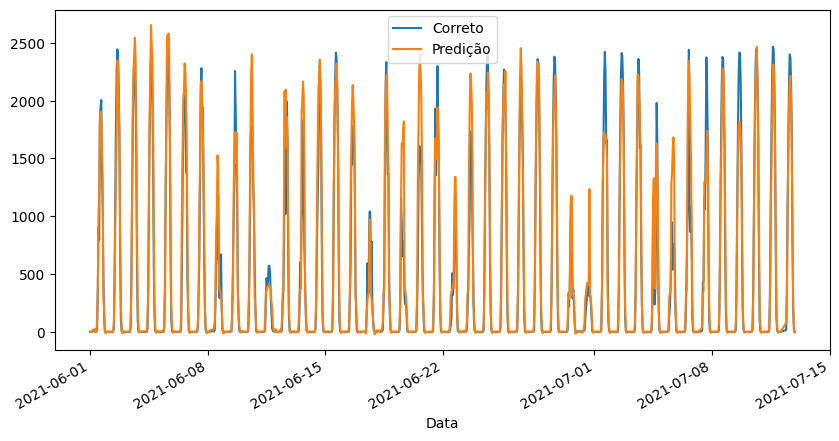

In [ ]:
plot_predictions(testing_dates[:1000], y_test, predictions)

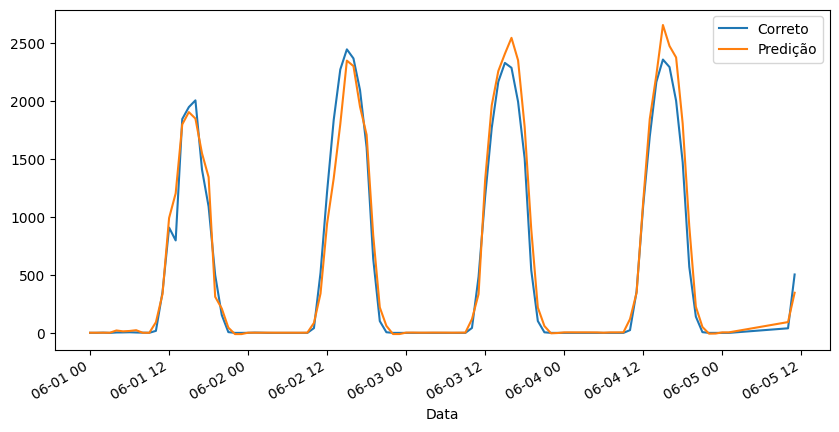

In [ ]:
plot_predictions(testing_dates[:100], y_test, predictions)

radiação solar presente entre as 09:00 e 19:00 que é quando o sol está presente

nos horários da madrugada radiação = 0